# Run vs Pass
is dropback prediction

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report


In [2]:
player_play = pd.read_csv("data/nfl-big-data-bowl-2025/player_play.csv")
games = pd.read_csv("data/nfl-big-data-bowl-2025/games.csv")
plays = pd.read_csv("data/nfl-big-data-bowl-2025/plays.csv")
players = pd.read_csv("data/nfl-big-data-bowl-2025/players.csv")

`isDropback` is the taget varibale in this case. If the QB dropped back that means the outcome is  pass, sack, or scramble

In [3]:
plays["isDropback"].value_counts()

isDropback
True     9736
False    6388
Name: count, dtype: int64

For starting out I want to filter the data that is just pre-snap data in the plays dataframe. I think the future possibility is looking adding tracking data to make the model more robust. Let's focus on just plays for now 

### Exploring the Data 

In [4]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [5]:
plays[plays["isDropback"]== True].groupby(["possessionTeam"]).size().reset_index().head()

,possessionTeam,0
0,ARI,375
1,ATL,237
2,BAL,283
3,BUF,316
4,CAR,271


In [6]:
# Group by possessionTeam and calculate the required metrics
grouped_plays_team = plays.groupby('possessionTeam')['isDropback'].agg(
    Total_Plays='size',
    Dropback_Plays='sum'
)


grouped_plays_team['Dropback_Rate'] = (grouped_plays_team['Dropback_Plays'] / grouped_plays_team['Total_Plays'])*100

grouped_plays_team.sort_values('Dropback_Rate', ascending=False, inplace=True)
grouped_plays_team.tail()

,Total_Plays,Dropback_Plays,Dropback_Rate
possessionTeam,,,
DAL,453,242,53.421634
CLE,512,269,52.539062
CHI,510,243,47.647059
ATL,511,237,46.379648
TEN,420,192,45.714286


When do teams choose to pass

<Axes: xlabel='yardsToGo', ylabel='Dropback_Rate'>

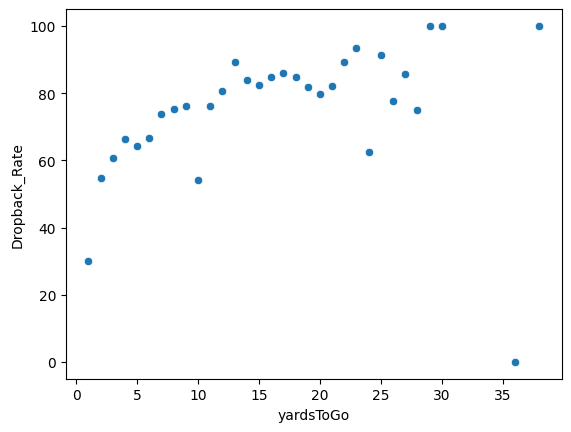

In [7]:
grouped_plays_YardstoGo = plays.groupby('yardsToGo')['isDropback'].agg(
    Total_Plays='size',
    Dropback_Plays='sum'
)

grouped_plays_YardstoGo['Dropback_Rate'] = (grouped_plays_YardstoGo['Dropback_Plays'] / grouped_plays_YardstoGo['Total_Plays'])*100

sns.scatterplot(x=grouped_plays_YardstoGo.index, y=grouped_plays_YardstoGo['Dropback_Rate'])

<Axes: xlabel='down', ylabel='Dropback_Rate'>

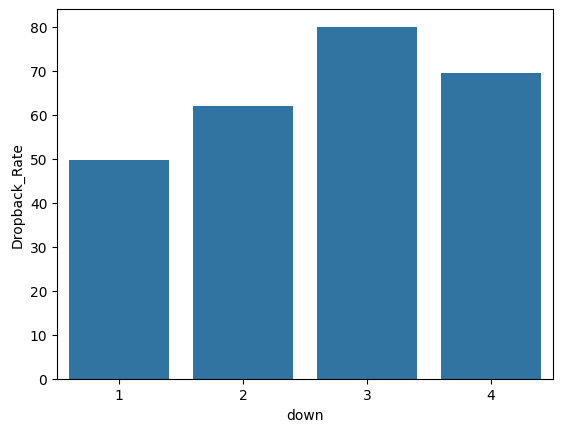

In [8]:
grouped_plays_Down = plays.groupby('down')['isDropback'].agg(
    Total_Plays='size',
    Dropback_Plays='sum'
)

grouped_plays_Down['Dropback_Rate'] = (grouped_plays_Down['Dropback_Plays'] / grouped_plays_Down['Total_Plays'])*100

sns.barplot(x=grouped_plays_Down.index, y=grouped_plays_Down['Dropback_Rate'])

## Feature Selection and Pre-processing

In [9]:
plays["offenseFormation"].unique()

array(['EMPTY', 'SHOTGUN', 'PISTOL', 'SINGLEBACK', nan, 'JUMBO', 'I_FORM',
       'WILDCAT'], dtype=object)

In [10]:
plays["offenseFormation"].value_counts()

offenseFormation
SHOTGUN       8791
SINGLEBACK    3915
EMPTY         1342
I_FORM        1035
PISTOL         641
JUMBO          125
WILDCAT         87
Name: count, dtype: int64

In [11]:
# Select pre-snap features
pre_snap_features = [
    'quarter', 'down', 'yardsToGo', 'yardlineNumber', 'isDropback',
    'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber', 
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 
    'expectedPoints', 'offenseFormation', 'receiverAlignment', 'playClockAtSnap'
] 

# Features that can be further studied gameClock 

pre_snap_data = plays[pre_snap_features]
pre_snap_data.head()

,quarter,down,yardsToGo,yardlineNumber,isDropback,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap
0,3,1,10,21,True,35,17,31,0.982017,0.017983,0.719313,EMPTY,3x2,10.0
1,4,1,10,8,True,17,17,18,0.424356,0.575644,0.607746,EMPTY,3x2,9.0
2,4,3,12,20,True,3,17,30,0.006291,0.993709,-0.291485,SHOTGUN,2x2,12.0
3,1,2,10,23,True,0,0,33,0.884223,0.115777,4.249382,SHOTGUN,2x2,11.0
4,3,2,8,27,False,10,10,37,0.410371,0.589629,3.928413,PISTOL,3x1,8.0


In [12]:
pre_snap_data.isnull().sum()

quarter                               0
down                                  0
yardsToGo                             0
yardlineNumber                        0
isDropback                            0
preSnapHomeScore                      0
preSnapVisitorScore                   0
absoluteYardlineNumber                0
preSnapHomeTeamWinProbability         0
preSnapVisitorTeamWinProbability      0
expectedPoints                        0
offenseFormation                    188
receiverAlignment                   188
playClockAtSnap                       1
dtype: int64

In [13]:
pre_snap_data.dropna(inplace=True)
pre_snap_data.isnull().sum()

/var/folders/xx/w3x7v3753jdc3rtcr5rvw8fw0000gn/T/ipykernel_18433/2783436859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_snap_data.dropna(inplace=True)


quarter                             0
down                                0
yardsToGo                           0
yardlineNumber                      0
isDropback                          0
preSnapHomeScore                    0
preSnapVisitorScore                 0
absoluteYardlineNumber              0
preSnapHomeTeamWinProbability       0
preSnapVisitorTeamWinProbability    0
expectedPoints                      0
offenseFormation                    0
receiverAlignment                   0
playClockAtSnap                     0
dtype: int64

In [14]:
pre_snap_data.head()

,quarter,down,yardsToGo,yardlineNumber,isDropback,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap
0,3,1,10,21,True,35,17,31,0.982017,0.017983,0.719313,EMPTY,3x2,10.0
1,4,1,10,8,True,17,17,18,0.424356,0.575644,0.607746,EMPTY,3x2,9.0
2,4,3,12,20,True,3,17,30,0.006291,0.993709,-0.291485,SHOTGUN,2x2,12.0
3,1,2,10,23,True,0,0,33,0.884223,0.115777,4.249382,SHOTGUN,2x2,11.0
4,3,2,8,27,False,10,10,37,0.410371,0.589629,3.928413,PISTOL,3x1,8.0


In [15]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, sparse_output=False)

# Fit and transform the offenseFormation and receiverAlignment columns
encoded_features = encoder.fit_transform(pre_snap_data[['offenseFormation', 'receiverAlignment']])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['offenseFormation', 'receiverAlignment']))

# Concatenate the encoded features with the original DataFrame
pre_snap_data_encoded = pd.concat([pre_snap_data.reset_index(drop=True), encoded_df], axis=1)

# Drop the original columns
pre_snap_data_encoded.drop(['offenseFormation', 'receiverAlignment'], axis=1, inplace=True)

pre_snap_data_encoded.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,quarter,down,yardsToGo,yardlineNumber,isDropback,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,...,receiverAlignment_1x1,receiverAlignment_2x0,receiverAlignment_2x1,receiverAlignment_2x2,receiverAlignment_3x0,receiverAlignment_3x1,receiverAlignment_3x2,receiverAlignment_3x3,receiverAlignment_4x1,receiverAlignment_4x2
0,3,1,10,21,True,35,17,31,0.982017,0.017983,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4,1,10,8,True,17,17,18,0.424356,0.575644,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,3,12,20,True,3,17,30,0.006291,0.993709,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,10,23,True,0,0,33,0.884223,0.115777,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2,8,27,False,10,10,37,0.410371,0.589629,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
# Assuming X and y are defined as follows:
X = pre_snap_data_encoded.drop(columns=['isDropback'])
y = pre_snap_data_encoded['isDropback']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
X_train.head()

,quarter,down,yardsToGo,yardlineNumber,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,...,receiverAlignment_1x1,receiverAlignment_2x0,receiverAlignment_2x1,receiverAlignment_2x2,receiverAlignment_3x0,receiverAlignment_3x1,receiverAlignment_3x2,receiverAlignment_3x3,receiverAlignment_4x1,receiverAlignment_4x2
3924,2,1,10,25,10,16,35,0.457982,0.542018,1.552477,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4326,4,3,6,38,3,24,72,0.001644,0.998356,0.708301,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4497,3,2,10,23,14,31,87,0.056309,0.943691,4.001166,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3302,1,1,10,19,0,0,91,0.788062,0.211938,0.756121,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
416,1,1,10,44,0,0,66,0.622062,0.377938,3.262238,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Modelling

In [17]:
model = LogisticRegression(random_state=16)
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=16)

In [18]:
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 74.40


In [19]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat)
cnf_matrix

array([[ 970,  589],
       [ 431, 1994]])

Text(0.5, 427.9555555555555, 'Predicted label')

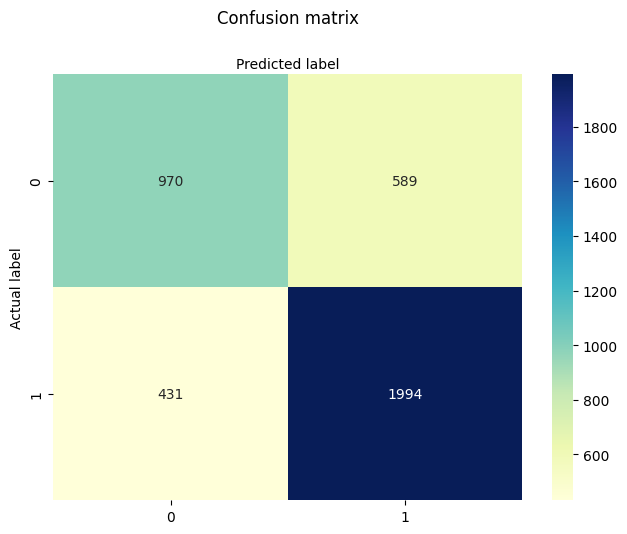

In [20]:
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [21]:
y_train.head()

3924    False
4326     True
4497    False
3302     True
416     False
Name: isDropback, dtype: bool

In [22]:
target_names = ['True', 'False']
print(classification_report(y_test, yhat, target_names=target_names))

              precision    recall  f1-score   support

        True       0.69      0.62      0.66      1559
       False       0.77      0.82      0.80      2425

    accuracy                           0.74      3984
   macro avg       0.73      0.72      0.73      3984
weighted avg       0.74      0.74      0.74      3984



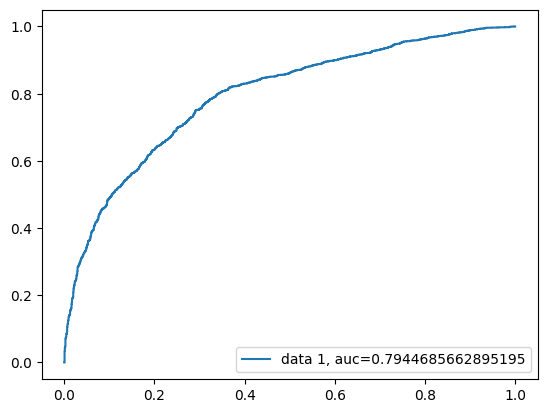

In [23]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [24]:
#end